### Pneumonia Dataset from Kaggle 
Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia<br>
Reference: Kermany, Daniel; Zhang, Kang;  Goldbaum, Michael (2018), "Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification", Mendeley Data, v2. DOI: 10.17632/rscbjbr9sj.2.
_________________
<table align="left">
    <tr>
        <th>Pneumonia</th>
        <th>Normal</th>
        <th>Total</th>
    </tr>
    <tr>
        <td style="text-align: center;">4273</td>
        <td style="text-align: center;">1583</td>
        <td style="text-align: center;">5863</td>
    </tr>
</table>

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# cnn
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

### Carregamento dos Dados

In [2]:
datadir = "C:\\Users\\robso\\CNN Pneumonia\\Data\\"
categories = ['Pneumonia', 'Normal']
x = []
y = []

for category in categories:
    path = os.path.join(datadir, category)
    
    for i in os.listdir(path):
        image = cv2.imread(os.path.join(path, i), cv2.IMREAD_GRAYSCALE)
        image = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        x.append(image)
        y.append(categories.index(category))

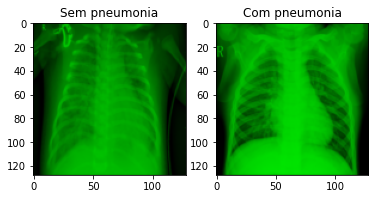

In [3]:
plt.subplot(121)
plt.title('Sem pneumonia')
plt.imshow(x[0])
plt.subplot(122)
plt.title('Com pneumonia')
plt.imshow(x[3000])

### Divisão do Conjunto de Dados

In [4]:
x = np.array(x)
y = np.array(y)

x2, x_test, y2, y_test = train_test_split(x, y, test_size=0.1, shuffle=True, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size=0.2, shuffle=True, stratify=y2)

inputs = np.concatenate((x_train, x_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

### Arquitetura e Treinamento da CNN

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

kfold = KFold(n_splits=5, shuffle=True)
acc_fold = []
loss_fold = []

for train, test in kfold.split(inputs, targets):
    model = Sequential()

    model.add(Flatten(input_shape=(128,128,3)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    
    results = model.fit(inputs[train], targets[train], epochs=10, validation_data=(inputs[test], targets[test]))
    score, acc = model.evaluate(inputs[test], targets[test], verbose=0)
    print('-----------------------------------------------')
    print(f'Score: {model.metrics_names[0]} de {score}; {model.metrics_names[1]} de {acc*100}%')
    acc_fold.append(acc*100)
    loss_fold.append(score)

print('\nMédia de todos folds')
print('-----------------------------------------------')
print(f'Acurácia: {np.mean(acc_fold)}% (+/- {np.std(acc_fold)}%)')
print(f'Loss: {np.mean(score)}%')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6291584   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
132/132 [==============================] - 12s 76ms/step - loss: 1.2602 - accuracy: 0.7220 - val_loss: 0.3156 - val_accuracy: 0.8786
Epoch 2/10
132/132 [==============================] - 7s 55ms/step - loss: 0.2937 - accuracy: 0.8723

Epoch 1/10
132/132 [==============================] - 12s 49ms/step - loss: 1.4538 - accuracy: 0.7529 - val_loss: 0.2174 - val_accuracy: 0.9194
Epoch 2/10
132/132 [==============================] - 7s 51ms/step - loss: 0.2716 - accuracy: 0.8855 - val_loss: 0.2080 - val_accuracy: 0.9203
Epoch 3/10
132/132 [==============================] - 7s 51ms/step - loss: 0.2292 - accuracy: 0.9066 - val_loss: 0.2218 - val_accuracy: 0.9156
Epoch 4/10
132/132 [==============================] - 6s 47ms/step - loss: 0.2539 - accuracy: 0.8951 - val_loss: 0.2295 - val_accuracy: 0.9023
Epoch 5/10
132/132 [==============================] - 6s 46ms/step - loss: 0.2416 - accuracy: 0.8978 - val_loss: 0.2274 - val_accuracy: 0.9175
Epoch 6/10
132/132 [==============================] - 6s 46ms/step - loss: 0.2557 - accuracy: 0.8975 - val_loss: 0.2131 - val_accuracy: 0.9137
Epoch 7/10
132/132 [==============================] - 6s 46ms/step - loss: 0.2458 - accuracy: 0.9028 - val_loss: 0.1857 - val_accuracy: 0.935

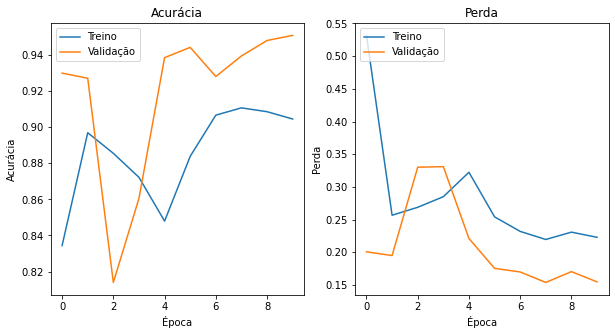

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.subplot(122)
plt.title('Perda')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.show()

### Teste da CNN

Métrica de avaliação		Resultado
---------------------------------------------
Acurácia:		 94.02730375426621 %
Precisão:		 87.73006134969326 %
Sensibilidade:		 90.50632911392405 %


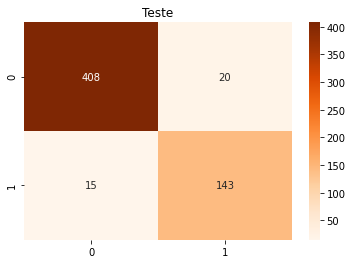

In [7]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

cmat=confusion_matrix(y_test,y_pred,labels=[0,1])
cm_df = pd.DataFrame(cmat)

tp = cmat[1][1]
fp = cmat[0][1]
tn = cmat[0][0]
fn = cmat[1][0]

accuracy = ((tp+tn)*100)/np.sum(cmat)
precision = (tp*100)/(tp+fp)
sensibility = (tp*100/(tp+fn))
specificity = (tn*100)/(fp+tn)

print('Métrica de avaliação\t\tResultado')
print('---------------------------------------------')
print('Acurácia:\t\t',accuracy,"%")
print('Precisão:\t\t',precision,"%")
print('Sensibilidade:\t\t',sensibility,"%")
                   
plt.title('Teste')
sns.heatmap(cm_df, annot=True, fmt="d", cmap=plt.cm.Oranges)
plt.show()

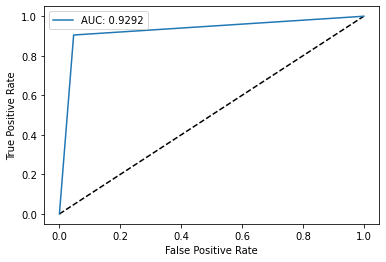

In [8]:
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(y_test, y_pred)
auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_cnn, tpr_cnn, label='AUC: {:.4f}'.format(auc_cnn))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()